# Notebook 04: Clustering Baseline Validation

## Why this notebook exists

Notebook 03 produced two candidate matrices:
- **full** (keep as much signal as possible)
- **pruned** (remove redundant behavioral features)

Here I benchmark clustering quality across both and document the result without forcing a "successful" clustering story.

## What this notebook does
1. Compare K-Means quality for full vs pruned matrices.
2. Choose `k` from measured metrics (not assumptions).
3. Benchmark K-Means against Hierarchical and DBSCAN.
4. Run stability checks (seed variation + bootstrap).
5. Save artifacts and a reproducible validation report.

## Evaluation stance
- Prefer better separation with reasonable cluster balance.
- If silhouette is weak, call it weak.
- Keep conclusions tied to computed outputs from this run.


---

## Setup

In [1]:

import json
import pickle
import warnings
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

warnings.simplefilter('default')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

INPUT_DIR = Path('data/processed_features')
OUTPUT_DIR = Path('data/clusters')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Environment ready.')
print(f'Random seed: {RANDOM_SEED}')
print(f'Input directory: {INPUT_DIR}')
print(f'Output directory: {OUTPUT_DIR}')


Environment ready.
Random seed: 42
Input directory: data/processed_features
Output directory: data/clusters


---

## Runtime Config


In [2]:
# Runtime toggles
SKIP_K2 = True
HIERARCHICAL_MAX_FIT_N = 20000

print('Runtime config:')
print(f'  SKIP_K2 = {SKIP_K2}')
print(f'  HIERARCHICAL_MAX_FIT_N = {HIERARCHICAL_MAX_FIT_N:,}')


Runtime config:
  SKIP_K2 = True
  HIERARCHICAL_MAX_FIT_N = 20,000



---

## 1) Load Full + Pruned Matrices


In [3]:

print('Loading clustering matrices from Notebook 03...')

full_matrix = pd.read_parquet(INPUT_DIR / 'final_clustering_matrix.parquet')
pruned_path = INPUT_DIR / 'final_clustering_matrix_pruned.parquet'
pruned_matrix = pd.read_parquet(pruned_path) if pruned_path.exists() else None

print()
print('✅ Matrix load complete:')
print(f'   Full matrix shape:   {full_matrix.shape}')
if pruned_matrix is not None:
    print(f'   Pruned matrix shape: {pruned_matrix.shape}')
else:
    print('   Pruned matrix: not found (full-only run)')

for name, df in [('full', full_matrix), ('pruned', pruned_matrix)]:
    if df is None:
        continue
    missing_count = int(df.isnull().sum().sum())
    inf_count = int(np.isinf(df.values).sum())
    print()
    print(f'{name} data quality:')
    print(f'   Missing values: {missing_count}')
    print(f'   Infinite values: {inf_count}')
    print(f'   Mean of features: {df.mean().mean():.6f}')
    print(f'   Std of features: {df.std().mean():.6f}')
    assert missing_count == 0, f'{name}: found missing values'
    assert inf_count == 0, f'{name}: found infinite values'

user_ids = full_matrix.index.to_numpy()
assert pruned_matrix is None or np.array_equal(user_ids, pruned_matrix.index.to_numpy()), 'Index mismatch between full and pruned matrices'

matrix_variants = {'full': full_matrix}
if pruned_matrix is not None:
    matrix_variants['pruned'] = pruned_matrix

print()
print('✅ Data quality validation passed for available matrices.')


Loading clustering matrices from Notebook 03...

✅ Matrix load complete:
   Full matrix shape:   (182223, 64)
   Pruned matrix shape: (182223, 61)

full data quality:
   Missing values: 0
   Infinite values: 0
   Mean of features: 0.000000
   Std of features: 1.083971

pruned data quality:
   Missing values: 0
   Infinite values: 0
   Mean of features: 0.000000
   Std of features: 1.088100

✅ Data quality validation passed for available matrices.



---

## 2) K-Means Grid Search (Per Matrix Variant)


In [4]:

print('=' * 70)
print('K-MEANS GRID SEARCH (FULL VS PRUNED)')
print('=' * 70)

k_range = range(2, 11)
all_results = []
variant_models = {}

for variant_name, df in matrix_variants.items():
    X_variant = df.values
    print()
    print(f'Evaluating variant: {variant_name} | shape={X_variant.shape}')
    variant_models[variant_name] = {}

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10, max_iter=300)
        labels = km.fit_predict(X_variant)

        sample_n = min(10000, len(X_variant))
        sample_idx = rng.choice(len(X_variant), sample_n, replace=False)
        sil = silhouette_score(X_variant[sample_idx], labels[sample_idx])

        cluster_sizes = Counter(labels)
        min_cluster_pct = min(cluster_sizes.values()) / len(X_variant) * 100
        max_cluster_pct = max(cluster_sizes.values()) / len(X_variant) * 100

        row = {
            'variant': variant_name,
            'k': k,
            'inertia': float(km.inertia_),
            'silhouette': float(sil),
            'calinski_harabasz': float(calinski_harabasz_score(X_variant, labels)),
            'davies_bouldin': float(davies_bouldin_score(X_variant, labels)),
            'min_cluster_pct': float(min_cluster_pct),
            'max_cluster_pct': float(max_cluster_pct),
        }
        all_results.append(row)
        variant_models[variant_name][k] = km
        print(f'  k={k}: silhouette={sil:.3f}, min_cluster={min_cluster_pct:.1f}%')

results_df = pd.DataFrame(all_results)

print()
print('✅ K-Means grid search complete.')
print()
print('Top candidates by silhouette:')
print(results_df.sort_values('silhouette', ascending=False).head(8).to_string(index=False))


K-MEANS GRID SEARCH (FULL VS PRUNED)

Evaluating variant: full | shape=(182223, 64)


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  cu

  k=2: silhouette=0.099, min_cluster=40.2%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=3: silhouette=0.004, min_cluster=25.3%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=4: silhouette=0.009, min_cluster=4.8%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=5: silhouette=0.013, min_cluster=1.1%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=6: silhouette=0.002, min_cluster=3.2%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=7: silhouette=0.004, min_cluster=1.0%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=8: silhouette=0.011, min_cluster=1.0%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=9: silhouette=-0.004, min_cluster=1.0%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=10: silhouette=-0.003, min_cluster=0.9%

Evaluating variant: pruned | shape=(182223, 61)


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=2: silhouette=0.130, min_cluster=31.8%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=3: silhouette=0.105, min_cluster=5.5%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=4: silhouette=0.007, min_cluster=4.6%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=5: silhouette=-0.021, min_cluster=3.5%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=6: silhouette=-0.017, min_cluster=1.0%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=7: silhouette=-0.014, min_cluster=1.0%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=8: silhouette=-0.011, min_cluster=1.0%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

  k=9: silhouette=-0.004, min_cluster=1.0%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


  k=10: silhouette=-0.024, min_cluster=1.0%

✅ K-Means grid search complete.

Top candidates by silhouette:
variant  k      inertia  silhouette  calinski_harabasz  davies_bouldin  min_cluster_pct  max_cluster_pct
 pruned  2 1.295548e+07    0.130164        7500.210100        4.380843        31.766572        68.233428
 pruned  3 1.264056e+07    0.104910        6113.352253        3.837652         5.504245        66.257278
   full  2 1.337471e+07    0.099096        9001.280378        4.083019        40.172755        59.827245
   full  5 1.249779e+07    0.012948        5604.546172        3.339788         1.057495        41.401470
   full  8 1.197181e+07    0.011274        4486.918331        3.372039         0.958715        21.918199
   full  4 1.271879e+07    0.008925        6287.514870        3.789530         4.761748        41.826773
 pruned  4 1.237627e+07    0.006786        5459.631022        3.981889         4.575712        36.671002
   full  3 1.303528e+07    0.003726        6990.3042

/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

### Visualize K-Means Quality by Variant

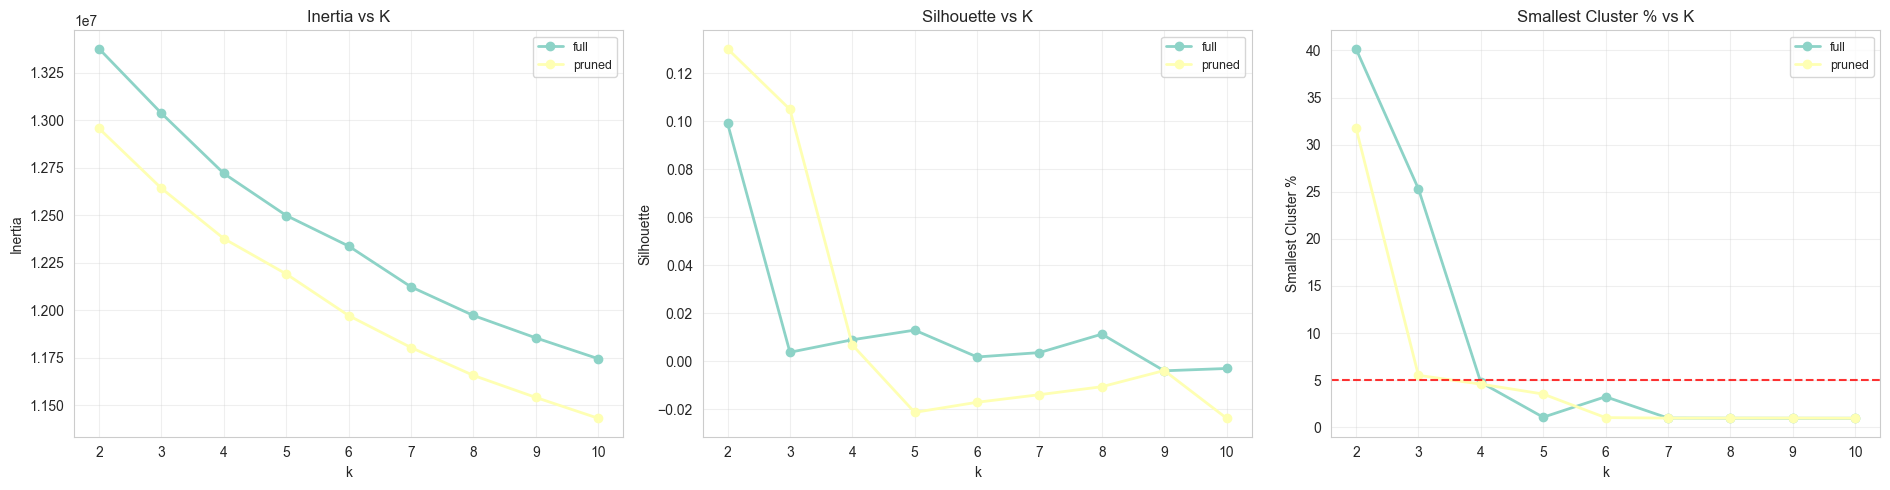


✅ Plot saved: kmeans_optimization.png


In [5]:

fig, axes = plt.subplots(1, 3, figsize=(19, 5))

for variant_name in results_df['variant'].unique():
    sub = results_df[results_df['variant'] == variant_name].sort_values('k')
    axes[0].plot(sub['k'], sub['inertia'], marker='o', linewidth=2, label=variant_name)
    axes[1].plot(sub['k'], sub['silhouette'], marker='o', linewidth=2, label=variant_name)
    axes[2].plot(sub['k'], sub['min_cluster_pct'], marker='o', linewidth=2, label=variant_name)

axes[0].set_title('Inertia vs K')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].grid(alpha=0.3)

axes[1].set_title('Silhouette vs K')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette')
axes[1].grid(alpha=0.3)

axes[2].set_title('Smallest Cluster % vs K')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Smallest Cluster %')
axes[2].axhline(5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
axes[2].grid(alpha=0.3)

for ax in axes:
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'kmeans_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print()
print('✅ Plot saved: kmeans_optimization.png')


### Select Matrix Variant and Optimal K

In [6]:
print('=' * 70)
print('SELECTION: MATRIX VARIANT + OPTIMAL K')
print('=' * 70)

sorted_candidates = results_df.sort_values(['silhouette', 'min_cluster_pct'], ascending=[False, False]).reset_index(drop=True)
if SKIP_K2:
    candidates = sorted_candidates[sorted_candidates['k'] > 2].reset_index(drop=True)
    if len(candidates) > 0:
        best = candidates.iloc[0]
        print('Selection rule applied: skipped k=2, chose next best candidate.')
    else:
        best = sorted_candidates.iloc[0]
        print('Selection rule fallback: no candidate with k>2 found, using top overall candidate.')
else:
    best = sorted_candidates.iloc[0]
    print('Selection rule applied: k=2 is allowed; using top overall candidate.')

selected_variant = str(best['variant'])
optimal_k = int(best['k'])
optimal_result = best
optimal_kmeans = variant_models[selected_variant][optimal_k]

clustering_matrix = matrix_variants[selected_variant]
X = clustering_matrix.values

print()
print('Selected configuration:')
print(f'  Variant: {selected_variant}')
print(f'  k: {optimal_k}')
print(f"  Silhouette: {optimal_result['silhouette']:.3f}")
print(f"  Smallest cluster: {optimal_result['min_cluster_pct']:.1f}%")

print()
print('Interpretation sanity:')
if optimal_result['silhouette'] >= 0.5:
    print('  Cluster separation: strong')
elif optimal_result['silhouette'] >= 0.3:
    print('  Cluster separation: moderate')
else:
    print('  Cluster separation: weak (likely overlapping behaviors)')

labels_optimal = optimal_kmeans.labels_


SELECTION: MATRIX VARIANT + OPTIMAL K
Selection rule applied: skipped k=2, chose next best candidate.

Selected configuration:
  Variant: pruned
  k: 3
  Silhouette: 0.105
  Smallest cluster: 5.5%

Interpretation sanity:
  Cluster separation: weak (likely overlapping behaviors)


---

## 3) Silhouette Distribution Check

SILHOUETTE DISTRIBUTION CHECK


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

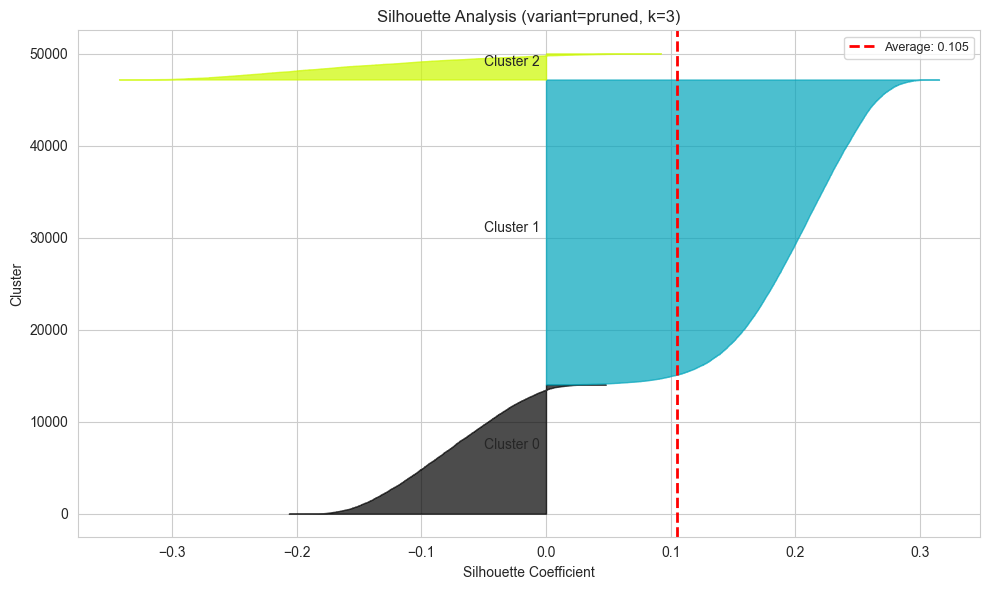


✅ Plot saved: silhouette_analysis.png


In [7]:

print('=' * 70)
print('SILHOUETTE DISTRIBUTION CHECK')
print('=' * 70)

sample_size = min(50000, len(X))
sample_indices = rng.choice(len(X), sample_size, replace=False)
X_sample = X[sample_indices]
labels_sample = labels_optimal[sample_indices]

silhouette_vals = silhouette_samples(X_sample, labels_sample)

fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
for i in range(optimal_k):
    vals = silhouette_vals[labels_sample == i]
    vals.sort()
    size_i = vals.shape[0]
    y_upper = y_lower + size_i
    color = plt.cm.nipy_spectral(float(i) / max(optimal_k, 1))
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_i, f'Cluster {i}')
    y_lower = y_upper + 10

ax.axvline(x=float(optimal_result['silhouette']), color='red', linestyle='--', linewidth=2, label=f"Average: {float(optimal_result['silhouette']):.3f}")
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title(f'Silhouette Analysis (variant={selected_variant}, k={optimal_k})')
ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'silhouette_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print()
print('✅ Plot saved: silhouette_analysis.png')


---

## 4) Hierarchical Clustering Benchmark

HIERARCHICAL BENCHMARK
Computing Ward linkage on sample n=5,000 ...


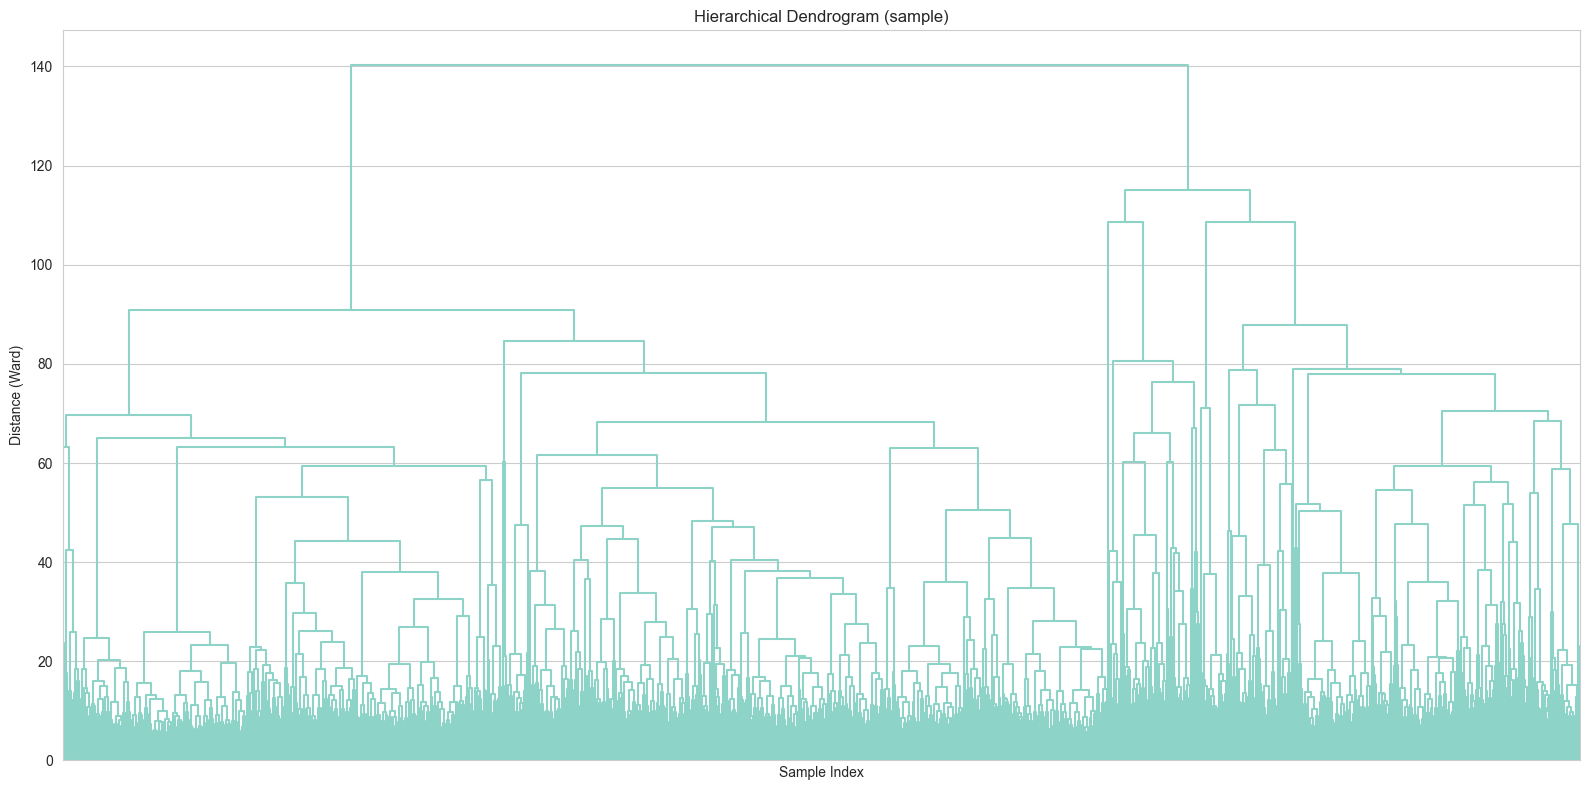


✅ Plot saved: dendrogram.png


In [8]:

print('=' * 70)
print('HIERARCHICAL BENCHMARK')
print('=' * 70)

sample_size = min(5000, len(X))
sample_indices = rng.choice(len(X), sample_size, replace=False)
X_h_sample = X[sample_indices]

print(f'Computing Ward linkage on sample n={sample_size:,} ...')
linkage_matrix = linkage(X_h_sample, method='ward')

fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(linkage_matrix, ax=ax, no_labels=True, color_threshold=0)
ax.set_xlabel('Sample Index')
ax.set_ylabel('Distance (Ward)')
ax.set_title('Hierarchical Dendrogram (sample)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

print()
print('✅ Plot saved: dendrogram.png')


### Fit Hierarchical with Selected k

In [9]:
print()
if len(X) > HIERARCHICAL_MAX_FIT_N:
    hierarchical_sample_idx = rng.choice(len(X), HIERARCHICAL_MAX_FIT_N, replace=False)
    X_h_eval = X[hierarchical_sample_idx]
    hierarchical_eval_scope = f'sample ({HIERARCHICAL_MAX_FIT_N:,} / {len(X):,})'
else:
    hierarchical_sample_idx = None
    X_h_eval = X
    hierarchical_eval_scope = 'full dataset'

print(f'Fitting Hierarchical clustering with k={optimal_k} on {hierarchical_eval_scope} ...')
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_h_eval)

hierarchical_silhouette = silhouette_score(
    X_h_eval,
    hierarchical_labels,
    sample_size=min(10000, len(X_h_eval)),
    random_state=RANDOM_SEED,
)
hierarchical_calinski = calinski_harabasz_score(X_h_eval, hierarchical_labels)
hierarchical_davies = davies_bouldin_score(X_h_eval, hierarchical_labels)
hierarchical_min_cluster_pct = float(min(Counter(hierarchical_labels).values()) / len(X_h_eval) * 100)

if hierarchical_sample_idx is None:
    hierarchical_labels_full = hierarchical_labels
else:
    hierarchical_labels_full = None

print()
print('Hierarchical metrics:')
print(f'  Scope: {hierarchical_eval_scope}')
print(f'  Silhouette: {hierarchical_silhouette:.3f}')
print(f'  Calinski-Harabasz: {hierarchical_calinski:.2f}')
print(f'  Davies-Bouldin: {hierarchical_davies:.3f}')
print(f'  Smallest cluster: {hierarchical_min_cluster_pct:.1f}%')



Fitting Hierarchical clustering with k=3 on sample (20,000 / 182,223) ...


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



Hierarchical metrics:
  Scope: sample (20,000 / 182,223)
  Silhouette: 0.088
  Calinski-Harabasz: 423.12
  Davies-Bouldin: 4.223
  Smallest cluster: 9.5%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

---

## 5) DBSCAN Benchmark (Sampled)

In [10]:

print('=' * 70)
print('DBSCAN BENCHMARK (SAMPLED)')
print('=' * 70)

eps_values = [1.0, 1.5, 2.0, 2.5, 3.0]
dbscan_rows = []

sample_size = min(20000, len(X))
sample_indices = rng.choice(len(X), sample_size, replace=False)
X_db = X[sample_indices]

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=50, n_jobs=-1)
    labels_db = db.fit_predict(X_db)
    n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    noise_pct = (labels_db == -1).mean() * 100

    sil = np.nan
    if n_clusters >= 2 and noise_pct < 95:
        mask = labels_db != -1
        if mask.sum() > n_clusters:
            sil = silhouette_score(X_db[mask], labels_db[mask])

    dbscan_rows.append({'eps': eps, 'n_clusters': n_clusters, 'noise_pct': float(noise_pct), 'silhouette': sil})
    print(f'  eps={eps}: clusters={n_clusters}, noise={noise_pct:.1f}%, silhouette={sil}')

dbscan_df = pd.DataFrame(dbscan_rows)
print()
print('DBSCAN summary:')
print(dbscan_df.to_string(index=False))


DBSCAN BENCHMARK (SAMPLED)
  eps=1.0: clusters=0, noise=100.0%, silhouette=nan
  eps=1.5: clusters=0, noise=100.0%, silhouette=nan
  eps=2.0: clusters=0, noise=100.0%, silhouette=nan
  eps=2.5: clusters=0, noise=100.0%, silhouette=nan
  eps=3.0: clusters=0, noise=100.0%, silhouette=nan

DBSCAN summary:
 eps  n_clusters  noise_pct  silhouette
 1.0           0      100.0         NaN
 1.5           0      100.0         NaN
 2.0           0      100.0         NaN
 2.5           0      100.0         NaN
 3.0           0      100.0         NaN


---

## 6) Algorithm Comparison and Final Selection

ALGORITHM COMPARISON

Comparison table:
           Algorithm  K  Silhouette  Calinski-Harabasz  Davies-Bouldin  Smallest Cluster % Matrix Variant
             K-Means  3    0.104910        6113.352253        3.837652            5.504245         pruned
Hierarchical(sample)  3    0.087986         423.117010        4.222644            9.510000         pruned
      DBSCAN(sample)  0         NaN                NaN             NaN                 NaN         pruned

Final algorithm selected: K-Means


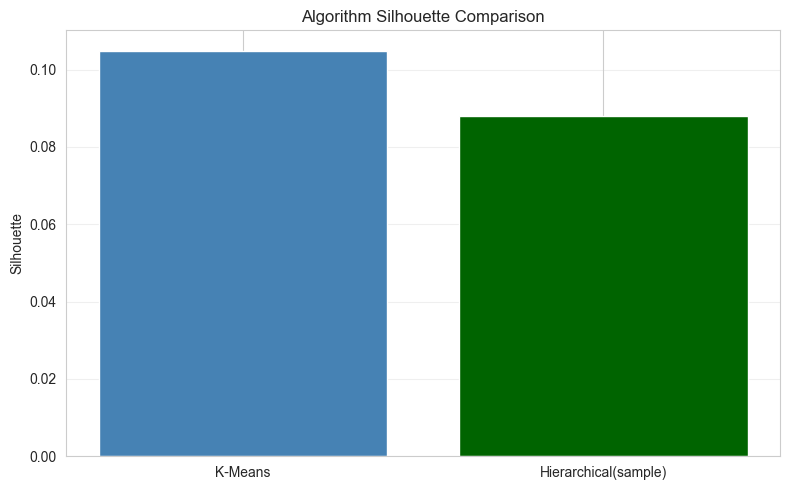

In [11]:
print('=' * 70)
print('ALGORITHM COMPARISON')
print('=' * 70)

kmeans_sil = float(optimal_result['silhouette'])
kmeans_cal = float(optimal_result['calinski_harabasz'])
kmeans_db = float(optimal_result['davies_bouldin'])
kmeans_minpct = float(optimal_result['min_cluster_pct'])

best_dbscan_sil = dbscan_df['silhouette'].dropna().max() if dbscan_df['silhouette'].notna().any() else np.nan
best_dbscan_row = dbscan_df.loc[dbscan_df['silhouette'].idxmax()] if np.isfinite(best_dbscan_sil) else None

hier_algo_name = 'Hierarchical' if hierarchical_labels_full is not None else 'Hierarchical(sample)'

comparison = pd.DataFrame([
    {'Algorithm': 'K-Means', 'K': optimal_k, 'Silhouette': kmeans_sil, 'Calinski-Harabasz': kmeans_cal, 'Davies-Bouldin': kmeans_db, 'Smallest Cluster %': kmeans_minpct, 'Matrix Variant': selected_variant},
    {'Algorithm': hier_algo_name, 'K': optimal_k, 'Silhouette': float(hierarchical_silhouette), 'Calinski-Harabasz': float(hierarchical_calinski), 'Davies-Bouldin': float(hierarchical_davies), 'Smallest Cluster %': hierarchical_min_cluster_pct, 'Matrix Variant': selected_variant},
    {'Algorithm': 'DBSCAN(sample)', 'K': int(best_dbscan_row['n_clusters']) if best_dbscan_row is not None else 0, 'Silhouette': float(best_dbscan_sil) if np.isfinite(best_dbscan_sil) else np.nan, 'Calinski-Harabasz': np.nan, 'Davies-Bouldin': np.nan, 'Smallest Cluster %': np.nan, 'Matrix Variant': selected_variant},
])

print()
print('Comparison table:')
print(comparison.to_string(index=False))
comparison.to_csv(OUTPUT_DIR / 'clustering_comparison.csv', index=False)

finite_comp = comparison[comparison['Silhouette'].notna()].copy()
best_algo = finite_comp.sort_values('Silhouette', ascending=False).iloc[0]['Algorithm']

if best_algo == 'K-Means':
    final_labels = labels_optimal
    final_model = optimal_kmeans
    final_metrics = {'silhouette': kmeans_sil, 'calinski': kmeans_cal, 'davies': kmeans_db, 'smallest_cluster_pct': kmeans_minpct}
elif best_algo.startswith('Hierarchical'):
    if hierarchical_labels_full is None:
        print()
        print('Hierarchical was best on sample only; using K-Means for full-dataset export to avoid long runtime.')
        final_labels = labels_optimal
        final_model = optimal_kmeans
        final_metrics = {'silhouette': kmeans_sil, 'calinski': kmeans_cal, 'davies': kmeans_db, 'smallest_cluster_pct': kmeans_minpct}
        best_algo = 'K-Means'
    else:
        final_labels = hierarchical_labels_full
        final_model = hierarchical
        final_metrics = {'silhouette': float(hierarchical_silhouette), 'calinski': float(hierarchical_calinski), 'davies': float(hierarchical_davies), 'smallest_cluster_pct': hierarchical_min_cluster_pct}
else:
    final_labels = labels_optimal
    final_model = optimal_kmeans
    final_metrics = {'silhouette': kmeans_sil, 'calinski': kmeans_cal, 'davies': kmeans_db, 'smallest_cluster_pct': kmeans_minpct}

print()
print(f'Final algorithm selected: {best_algo}')

fig, ax = plt.subplots(figsize=(8,5))
plot_df = finite_comp.copy()
ax.bar(plot_df['Algorithm'], plot_df['Silhouette'], color=['steelblue','darkgreen','orange'][:len(plot_df)])
ax.set_ylabel('Silhouette')
ax.set_title('Algorithm Silhouette Comparison')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'clustering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


---

## 7) Stability Validation

In [12]:

print('=' * 70)
print('STABILITY VALIDATION')
print('=' * 70)

seed_aris = []
for seed in range(10):
    km = KMeans(n_clusters=optimal_k, random_state=seed, n_init=10, max_iter=300)
    labels_test = km.fit_predict(X)
    seed_aris.append(adjusted_rand_score(labels_optimal, labels_test))
mean_seed_ari = float(np.mean(seed_aris))

bootstrap_aris = []
for i in range(5):
    sample_idx = rng.choice(len(X), int(0.9 * len(X)), replace=True)
    X_boot = X[sample_idx]
    km_boot = KMeans(n_clusters=optimal_k, random_state=RANDOM_SEED, n_init=10, max_iter=300)
    km_boot.fit(X_boot)
    labels_pred = km_boot.predict(X)
    bootstrap_aris.append(adjusted_rand_score(labels_optimal, labels_pred))
mean_bootstrap_ari = float(np.mean(bootstrap_aris))

print()
print(f'Mean ARI (seed variation): {mean_seed_ari:.3f}')
print(f'Mean ARI (bootstrap): {mean_bootstrap_ari:.3f}')


STABILITY VALIDATION


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  cu


Mean ARI (seed variation): 0.997
Mean ARI (bootstrap): 0.986


---

## 8) Save Final Outputs and Validation Report

In [13]:

print('Saving final clustering solution...')

cluster_assignments = pd.DataFrame({'user_id': user_ids, 'cluster': final_labels})
cluster_assignments.to_parquet(OUTPUT_DIR / 'cluster_labels.parquet', index=False)

if isinstance(final_model, KMeans):
    centers = pd.DataFrame(final_model.cluster_centers_, columns=clustering_matrix.columns)
    centers.to_csv(OUTPUT_DIR / 'cluster_centers.csv', index=False)

with open(OUTPUT_DIR / 'clustering_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

metrics = pd.DataFrame([{
    'algorithm_selected': type(final_model).__name__,
    'matrix_variant': selected_variant,
    'n_clusters': optimal_k,
    'silhouette_score': final_metrics['silhouette'],
    'calinski_harabasz': final_metrics['calinski'],
    'davies_bouldin': final_metrics['davies'],
    'smallest_cluster_pct': final_metrics['smallest_cluster_pct'],
    'stability_seed_ari': mean_seed_ari,
    'stability_bootstrap_ari': mean_bootstrap_ari,
}])
metrics.to_csv(OUTPUT_DIR / 'clustering_metrics.csv', index=False)

comparison.to_csv(OUTPUT_DIR / 'clustering_comparison.csv', index=False)

report_lines = [
    'NOTEBOOK 04 VALIDATION REPORT',
    '=' * 70,
    f'selected_matrix_variant: {selected_variant}',
    f'selected_algorithm: {type(final_model).__name__}',
    f'optimal_k: {optimal_k}',
    f'silhouette: {final_metrics["silhouette"]:.4f}',
    f'calinski_harabasz: {final_metrics["calinski"]:.2f}',
    f'davies_bouldin: {final_metrics["davies"]:.4f}',
    f'smallest_cluster_pct: {final_metrics["smallest_cluster_pct"]:.2f}',
    f'stability_seed_ari: {mean_seed_ari:.4f}',
    f'stability_bootstrap_ari: {mean_bootstrap_ari:.4f}',
    '',
    'matrix_variant_comparison (best silhouette by variant):',
]

best_by_variant = results_df.sort_values('silhouette', ascending=False).groupby('variant', as_index=False).first()
for _, r in best_by_variant.iterrows():
    report_lines.append(f"  - {r['variant']}: k={int(r['k'])}, silhouette={r['silhouette']:.4f}, min_cluster_pct={r['min_cluster_pct']:.2f}")

(OUTPUT_DIR / 'cluster_validation_report.txt').write_text('\\n'.join(report_lines))

print('✅ Saved: cluster_labels.parquet')
if isinstance(final_model, KMeans):
    print('✅ Saved: cluster_centers.csv')
print('✅ Saved: clustering_model.pkl')
print('✅ Saved: clustering_metrics.csv')
print('✅ Saved: clustering_comparison.csv')
print('✅ Saved: clustering_comparison.png')
print('✅ Saved: cluster_validation_report.txt')
print()
print(f'📁 All outputs saved to: {OUTPUT_DIR}')


Saving final clustering solution...
✅ Saved: cluster_labels.parquet
✅ Saved: cluster_centers.csv
✅ Saved: clustering_model.pkl
✅ Saved: clustering_metrics.csv
✅ Saved: clustering_comparison.csv
✅ Saved: clustering_comparison.png
✅ Saved: cluster_validation_report.txt

📁 All outputs saved to: data/clusters


---

## 9) Final Summary

In [14]:

print()
print('='*80)
print('NOTEBOOK 04: CLUSTERING VALIDATION COMPLETE')
print('='*80)

print()
print(f'Selected matrix variant: {selected_variant}')
print(f'Selected algorithm: {type(final_model).__name__}')
print(f'k: {optimal_k}')
print(f'Users clustered: {len(final_labels):,}')

print()
print('Quality metrics:')
print(f"  Silhouette: {final_metrics['silhouette']:.3f}")
print(f"  Calinski-Harabasz: {final_metrics['calinski']:.2f}")
print(f"  Davies-Bouldin: {final_metrics['davies']:.3f}")
print(f"  Smallest cluster: {final_metrics['smallest_cluster_pct']:.1f}%")

print()
print('Stability:')
print(f'  Seed ARI: {mean_seed_ari:.3f}')
print(f'  Bootstrap ARI: {mean_bootstrap_ari:.3f}')

print()
print('Interpretation sanity:')
if final_metrics['silhouette'] >= 0.5:
    print('  Cluster separation appears strong.')
elif final_metrics['silhouette'] >= 0.3:
    print('  Cluster separation is moderate.')
else:
    print('  Cluster separation is weak; treat segmentation boundaries cautiously.')

print()
print('Next: treat this as baseline, then check Notebook 06 for non-aisle clustering and use Notebook 07 for production-ready segmentation.')
print('='*80)



NOTEBOOK 04: CLUSTERING VALIDATION COMPLETE

Selected matrix variant: pruned
Selected algorithm: KMeans
k: 3
Users clustered: 182,223

Quality metrics:
  Silhouette: 0.105
  Calinski-Harabasz: 6113.35
  Davies-Bouldin: 3.838
  Smallest cluster: 5.5%

Stability:
  Seed ARI: 0.997
  Bootstrap ARI: 0.986

Interpretation sanity:
  Cluster separation is weak; treat segmentation boundaries cautiously.

Next: Notebook 05 (all-feature ablation), then Notebook 06, then Notebook 07


## Decision Update

This notebook is the baseline checkpoint for PCA-based clustering.

- Result: separation stays in the low `0.10` range.
- Follow-up ablations (`04b`, `04c`) decide whether feature design can improve that.
- Final portfolio direction: keep clustering as exploratory evidence, then use Notebook 07 as the production segmentation layer.
